*MOOC Completion Prediction*
1. Data Preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [2]:
# Importing the dataset
df = pd.read_csv("MOOC_AGG_1NF.csv")
df.head()


,user_id,course_id,completion,local_watch,video_duration,watching_count,video_count
0,1,C_course-v1:TsinghuaX+00740043X_2015_T2+sp,0,7697,8439.0,34,18
1,1,C_course-v1:TsinghuaX+00740113_1X+sp,0,1618,1612.0,10,3
2,1,C_course-v1:TsinghuaX+30240184+sp,0,1386,1155.0,7,5
3,1,C_course-v1:TsinghuaX+30240243X+sp,0,2614,2612.0,7,4
4,1,C_course-v1:TsinghuaX+00740113_2X+sp,1,527,1684.0,5,2


In [3]:
# read another dataset
df2 = pd.read_csv("MOOC_Course_count.csv")
df2['counts'] = df2['counts'].astype(int)

# print type for each column
print(df2.dtypes)
print(df.dtypes)


course_id    object
counts        int64
dtype: object
user_id             int64
course_id          object
completion          int64
local_watch         int64
video_duration    float64
watching_count      int64
video_count         int64
dtype: object


In [4]:
# join tables to get information
df_new = pd.merge(df, df2, how="left", on="course_id")
df_new.head()

,user_id,course_id,completion,local_watch,video_duration,watching_count,video_count,counts
0,1,C_course-v1:TsinghuaX+00740043X_2015_T2+sp,0,7697,8439.0,34,18,115
1,1,C_course-v1:TsinghuaX+00740113_1X+sp,0,1618,1612.0,10,3,36
2,1,C_course-v1:TsinghuaX+30240184+sp,0,1386,1155.0,7,5,235
3,1,C_course-v1:TsinghuaX+30240243X+sp,0,2614,2612.0,7,4,137
4,1,C_course-v1:TsinghuaX+00740113_2X+sp,1,527,1684.0,5,2,55


In [5]:
# feature engineering

df_new.rename(columns={'video_count': 'episodes_watched', 'video_duration': 'video_total', "completion" : "dropped"}, inplace=True)
df_new['episodes_percentile'] = df_new.apply(lambda x: x['episodes_watched'] / x['counts'], axis=1)
df_new['watching_speed'] = df_new.apply(lambda x: x['local_watch'] / x['video_total'], axis=1)
df_new.drop(['counts'], axis=1, inplace=True)

df_new.head()

#export to csv
df_new.to_csv('MOOC_AGG_1NF_all.csv', index=False)




2. Create dictionary to convert string to int and enable the model to process the data

In [6]:
# create a dictionary for string to int conversion
dict_1 = {}
for i, k in enumerate(df_new['course_id'].unique()):
    dict_1[k] = i

# apply that dictionary to the dataset

for i in range(len(df_new['course_id'])):
    df_new['course_id'][i] = dict_1.get(df_new['course_id'][i])



df_new.head()


/var/folders/w5/8p8hjbzs55d977j35rr3ls4w0000gn/T/ipykernel_3699/1855487061.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['course_id'][i] = dict_1.get(df_new['course_id'][i])


,user_id,course_id,dropped,local_watch,video_total,watching_count,episodes_watched,episodes_percentile,watching_speed
0,1,0,0,7697,8439.0,34,18,0.156522,0.912075
1,1,1,0,1618,1612.0,10,3,0.083333,1.003722
2,1,2,0,1386,1155.0,7,5,0.021277,1.200000
3,1,3,0,2614,2612.0,7,4,0.029197,1.000766
4,1,4,1,527,1684.0,5,2,0.036364,0.312945


In [7]:
training_data, testing_data = train_test_split(df_new, test_size=0.2, random_state=25)
testing_data.head()

,user_id,course_id,dropped,local_watch,video_total,watching_count,episodes_watched,episodes_percentile,watching_speed
1699,318,23,0,569,1946.0,13,4,0.049383,0.292395
104452,18989,87,0,9012,7145.0,71,14,0.125000,1.261302
15058,2755,111,1,8295,8679.0,63,14,0.093333,0.955755
221723,40241,62,0,36345,4706.0,61,8,0.095238,7.723119
11168,2040,174,0,1668,1268.0,27,16,0.216216,1.315457


In [8]:
actaul_training_data1 = training_data.drop(['dropped'], axis=1)
actaul_training_data = actaul_training_data1.drop(['user_id'], axis=1)
actaul_training_data.head()

actaul_training_label = training_data['dropped']

actaul_training_data.describe()


,local_watch,video_total,watching_count,episodes_watched,episodes_percentile,watching_speed
count,1.823470e+05,182347.000000,182347.000000,182347.000000,182347.000000,182347.000000
mean,1.001487e+04,7534.285286,81.357171,14.465025,0.156127,1.042955
std,2.593600e+04,10809.203539,209.506931,23.485315,0.196244,3.006726
min,0.000000e+00,15.000000,1.000000,1.000000,0.001961,0.000000
25%,4.800000e+02,1159.000000,6.000000,2.000000,0.026786,0.423180
50%,2.074000e+03,3022.000000,19.000000,5.000000,0.071429,0.740958
75%,8.393500e+03,9002.000000,70.000000,16.000000,0.195122,1.032295
max,1.659818e+06,156099.000000,11832.000000,271.000000,1.600000,426.111111


3. Testing different models (random forest, adaboost, gradientboost)

In [10]:

#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=445, max_depth=10)
rf.fit(actaul_training_data, actaul_training_label)



RandomForestClassifier(max_depth=10, random_state=445)

In [11]:

# cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, actaul_training_data, actaul_training_label)
print("Cross-validated scores:", scores)
print("Mean:", scores.mean())



Cross-validated scores: [0.79679188 0.79149986 0.79297486 0.79541528 0.7931668 ]
Mean: 0.7939697370821978


In [10]:
actaul_testing_data1 = testing_data.drop(['dropped'], axis=1)
actaul_testing_data = actaul_testing_data1.drop(['user_id'], axis=1)
actaul_testing_data.head()

actaul_testing_label = testing_data['dropped']


In [76]:
# Predicting the Test set results
y_pred = rf.predict(actaul_testing_data)

#testing scores
print("Accuracy:",sklearn.metrics.accuracy_score(actaul_testing_label, y_pred))
print("Precision:",sklearn.metrics.precision_score(actaul_testing_label, y_pred))
print("Recall:",sklearn.metrics.recall_score(actaul_testing_label, y_pred))
print("F1:",sklearn.metrics.f1_score(actaul_testing_label, y_pred))



Accuracy: 0.7986487375786957
Precision: 0.6781422246317882
Recall: 0.5719402530102119
F1: 0.6205299929720122


In [14]:
# test AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=100, random_state=445)
ada.fit(actaul_training_data, actaul_training_label)

#testing scores
y_pred_adp = ada.predict(actaul_testing_data)
print("Accuracy:",sklearn.metrics.accuracy_score(actaul_testing_label, y_pred_adp))
print("Precision:",sklearn.metrics.precision_score(actaul_testing_label, y_pred_adp))
print("Recall:",sklearn.metrics.recall_score(actaul_testing_label, y_pred_adp))
print("F1:",sklearn.metrics.f1_score(actaul_testing_label, y_pred_adp))



/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7884923333406454
Precision: 0.6405265708286222
Recall: 0.6044048163389727
F1: 0.6219416562107905


In [11]:
# test GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 10, 15, 20, 25]}
gb = GradientBoostingClassifier(random_state=445)
grid_search = GridSearchCV(gb, param_grid, cv=5, n_jobs=-1)

grid_search.fit(actaul_training_data, actaul_training_label)
print(grid_search.best_params_)

/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 10, 'n_estimators': 300}


In [12]:
gb = GradientBoostingClassifier(random_state=445, n_estimators=300, max_depth=10)
gb.fit(actaul_training_data, actaul_training_label)

#testing scores
y_pred_gb = gb.predict(actaul_testing_data)
print("Accuracy:",sklearn.metrics.accuracy_score(actaul_testing_label, y_pred_gb))
print("Precision:",sklearn.metrics.precision_score(actaul_testing_label, y_pred_gb))
print("Recall:",sklearn.metrics.recall_score(actaul_testing_label, y_pred_gb))
print("F1:",sklearn.metrics.f1_score(actaul_testing_label, y_pred_gb))



Accuracy: 0.8285037401013446
Precision: 0.7207792207792207
Recall: 0.6598079561042524
F1: 0.6889472427787061


In [20]:
#attempt XGBoost
from xgboost import XGBClassifier

actaul_training_data['course_id'] = actaul_training_data['course_id'].astype('int')

actaul_training_data.dtypes

actaul_testing_data['course_id'] = actaul_testing_data['course_id'].astype('int')



In [0]:
xgb = XGBClassifier(random_state=445, n_estimators=300, max_depth=10)
xgb.fit(actaul_training_data, actaul_training_label)


In [21]:
# testing scores
y_pred_xgb = xgb.predict(actaul_testing_data)
print("Accuracy:",sklearn.metrics.accuracy_score(actaul_testing_label, y_pred_xgb))
print("Precision:",sklearn.metrics.precision_score(actaul_testing_label, y_pred_xgb))
print("Recall:",sklearn.metrics.recall_score(actaul_testing_label, y_pred_xgb))
print("F1:",sklearn.metrics.f1_score(actaul_testing_label, y_pred_xgb))


Accuracy: 0.8260907714918727
Precision: 0.7139561707035755
Recall: 0.6604176192653559
F1: 0.6861441013460016


4. Unsupservised Learning

/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/ana

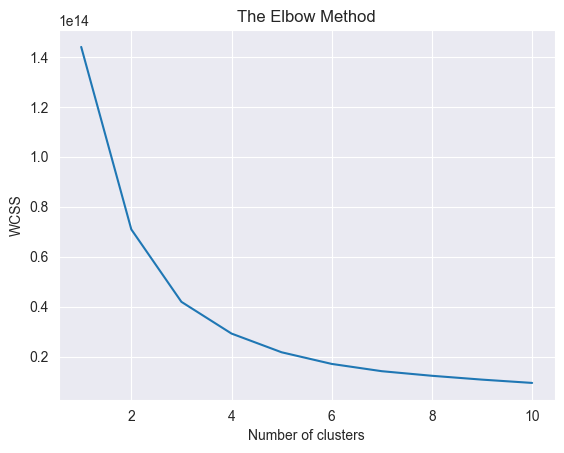

In [11]:
# K-Means Clustering
from sklearn.cluster import KMeans

# generate the elbow plot
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=445)
    kmeans.fit(actaul_training_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


/opt/anaconda3/envs/MLEnv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


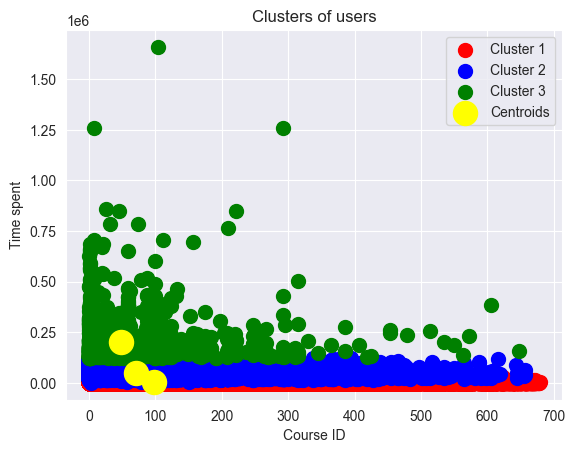

In [12]:
# use 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=445)
y_kmeans = kmeans.fit_predict(actaul_training_data)

#plot the clusters
plt.scatter(actaul_training_data.iloc[y_kmeans == 0, 0], actaul_training_data.iloc[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(actaul_training_data.iloc[y_kmeans == 1, 0], actaul_training_data.iloc[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(actaul_training_data.iloc[y_kmeans == 2, 0], actaul_training_data.iloc[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of users')
plt.xlabel('Course ID')
plt.ylabel('Time spent')
plt.legend()
plt.show()


In [15]:
# calculate the silhouette score
from sklearn.metrics import silhouette_score
silhouette_score(actaul_training_data, y_kmeans, n_jobs = -1)

0.7833917883556046

In [14]:

actaul_testing_data.describe()

,local_watch,video_total,watching_count,episodes_watched,episodes_percentile,watching_speed
count,45587.000000,45587.000000,45587.000000,45587.000000,45587.000000,45587.000000
mean,9814.857196,7426.196927,81.523592,14.273894,0.154899,1.034817
std,25149.032317,10634.253054,208.749551,23.152246,0.194900,2.311533
min,0.000000,15.000000,1.000000,1.000000,0.001961,0.000000
25%,482.000000,1159.000000,6.000000,2.000000,0.026786,0.419703
50%,2043.000000,3000.000000,19.000000,5.000000,0.070707,0.738748
75%,8274.000000,8842.500000,69.000000,16.000000,0.192982,1.032269
max,987183.000000,120444.000000,6967.000000,219.000000,1.407895,126.626335
